In [1]:
!pip install langgraph langchain-oci



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from langchain_oci import ChatOCIGenAI

# --- 1. Configure OCI LLM ---
# Informações de autenticação (substituia pelas suas!)
COMPARTMENT_ID = "ocid1.tenancy.oc1..aaaaaaaakzuzfystmhyj7je5x7ymwd3ofd7wb6rtsfrx7nvbo272vta3rwna" 
AUTH_TYPE = "API_KEY"
CONFIG_PROFILE = "CHICAGOV2"
endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"

# Inicializa o modelo na GenAI
model = ChatOCIGenAI(
  model_id="ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyavwbgai5nlntsd5hngaileroifuoec5qxttmydhq7mykq",
  service_endpoint=endpoint,
  compartment_id=COMPARTMENT_ID,
  provider="meta",
  model_kwargs={
    "temperature": 0,
    "max_tokens": 600
  },
  auth_type=AUTH_TYPE,
  auth_profile=CONFIG_PROFILE
)

# --- 2. Teste o modelo ---
model.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm doing great, thanks for asking—always ready to assist with whatever's on your mind. How about you? 😊", additional_kwargs={'finish_reason': 'stop', 'time_created': '2025-11-18 16:30:19.735000+00:00'}, response_metadata={'model_id': 'ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyavwbgai5nlntsd5hngaileroifuoec5qxttmydhq7mykq', 'model_version': '1.0.0', 'request_id': '7F6E2AFBF1BC48A98F7D3B54DA3EB5E2/1EB818EDF60F2573B071BC4FD2E6EB85/7E9D995C04A0BFF3BAD55641A0610899', 'content-length': '465', 'finish_reason': 'stop', 'time_created': '2025-11-18 16:30:19.735000+00:00'}, id='run-9e4dee98-0f72-4a73-8063-3aa8ca5a777b-0')

In [12]:
# Step 3: Define tools

from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

#'--- Teste o modelo com ferramentas ---
model_with_tools.invoke("What's 15 multiplied by 10, then add 20 and divide by 5?")


AIMessage(content="I need to perform the operations step by step. First, I'll multiply 15 by 10.\n\n", additional_kwargs={'finish_reason': 'tool_calls', 'time_created': '2025-11-18 16:30:29.435000+00:00', 'tool_calls': [{'id': 'call_21355787', 'function': {'name': 'multiply', 'arguments': {'a': 15, 'b': 10}}, 'type': 'function'}]}, response_metadata={'model_id': 'ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyavwbgai5nlntsd5hngaileroifuoec5qxttmydhq7mykq', 'model_version': '1.0.0', 'request_id': '9D31C794D7B549EC93C97C5F8F228AE1/0B49110067290A630B2241D249591F5E/8350125C800D997A0882FD601EBAD084', 'content-length': '489', 'finish_reason': 'tool_calls', 'time_created': '2025-11-18 16:30:29.435000+00:00', 'tool_calls': [{'id': 'call_21355787', 'function': {'name': 'multiply', 'arguments': {'a': 15, 'b': 10}}, 'type': 'function'}]}, id='run-85f0e119-42fc-4004-a7e4-f4475a101a52-0', tool_calls=[{'name': 'multiply', 'args': {'a': 15, 'b': 10}, 'id': 'call_21355787', 'type': 'tool_call

In [13]:
# Step 4: Define state

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int


In [14]:
# Step 5: Define model node
from langchain_core.messages import SystemMessage


def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or give the final answer."""
    system_prompt = SystemMessage(
        content=(
            "You are a helpful assistant who can use tools to perform arithmetic.\n"
            "If you already have all the necessary information, reply directly to the user.\n"
            "Use tool when is needed.\n"
        )
    )

    messages = [system_prompt] + state["messages"]
    llm_output = model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [llm_output],
        "llm_calls": state.get("llm_calls", 0) + 1,
    }




In [15]:
# Step 6: Define tool node

from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    new_messages = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        # Include clear textual result for the LLM
        new_messages.append(
            ToolMessage(
                content=f"Tool {tool_call['name']} returned: {result}",
                tool_call_id=tool_call["id"]
            )
        )
    return {"messages": new_messages}



In [16]:
# Step 7: Define logic to determine whether to end

from typing import Literal
from langgraph.graph import StateGraph, START, END


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    messages = state["messages"]
    print(state)

    # Stop after 5 LLM calls (safety)
    if state.get("llm_calls", 0) > 5:
        return END

    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return "tool_node"
    return END



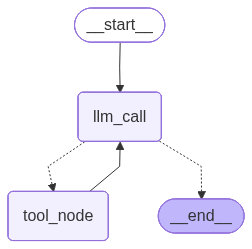

In [17]:
# Step 8: Build agent

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()


from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [18]:
# Step 9: Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="What's 15 multiplied by 10, then add 20 and divide by 5?")]
messages = agent.invoke({"messages": messages})


{'messages': [HumanMessage(content="What's 15 multiplied by 10, then add 20 and divide by 5?", additional_kwargs={}, response_metadata={}), HumanMessage(content="What's 15 multiplied by 10, then add 20 and divide by 5?", additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'finish_reason': 'tool_calls', 'time_created': '2025-11-18 16:30:47.374000+00:00', 'tool_calls': [{'id': 'call_80033320', 'function': {'name': 'multiply', 'arguments': {'a': 15, 'b': 10}}, 'type': 'function'}]}, response_metadata={'model_id': 'ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyavwbgai5nlntsd5hngaileroifuoec5qxttmydhq7mykq', 'model_version': '1.0.0', 'request_id': '77C429284E7647A08068E061E43511C5/E999D76DBEC690278D534A57E159F860/3FBC76FB283C66B6DB9B9B90AF238EE6', 'content-length': '435', 'finish_reason': 'tool_calls', 'time_created': '2025-11-18 16:30:47.374000+00:00', 'tool_calls': [{'id': 'call_80033320', 'function': {'name': 'multiply', 'arguments': {'a': 15, 

In [19]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What's 15 multiplied by 10, then add 20 and divide by 5?
================================ Human Message =================================

What's 15 multiplied by 10, then add 20 and divide by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_80033320)
 Call ID: call_80033320
  Args:
    a: 15
    b: 10
================================= Tool Message =================================

Tool multiply returned: 150
================================ Human Message =================================

What's 15 multiplied by 10, then add 20 and divide by 5?
================================ Human Message =================================

What's 15 multiplied by 10, then add 20 and divide by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_80033320)
 Call ID: call_80033320
  Args:
    a: 15
